# Fit Multiple Data Sets With Multiple Components

### Bloembergen-Purcell-Pound (BPP) function

This example shows how to use `lmfit_global.LmfitGlobal` class to fit multi-dataset with Bloembergen-Purcell-Pound (BPP) function with multiple relaxation processes. 

This is an example to results published in `[Figure 4 (a)]` [Phys. Rev. B 111, 014444 (2025)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.111.014444) 

In [1]:
try:
    from lmfit_global import LmfitGlobal
    from lmfit_global.util.utils import GlobalFitBuilder
except (ImportError, ModuleNotFoundError):
    import os, sys
    ROOT = os.path.abspath("..")  # parent of examples
    sys.path.insert(0, ROOT)

    from lmfit_global import LmfitGlobal
    from lmfit_global.util.utils import GlobalFitBuilder

import matplotlib
import matplotlib.pyplot as plt

# Define `LmfitGlobal` class `items` data

First, load raw data...

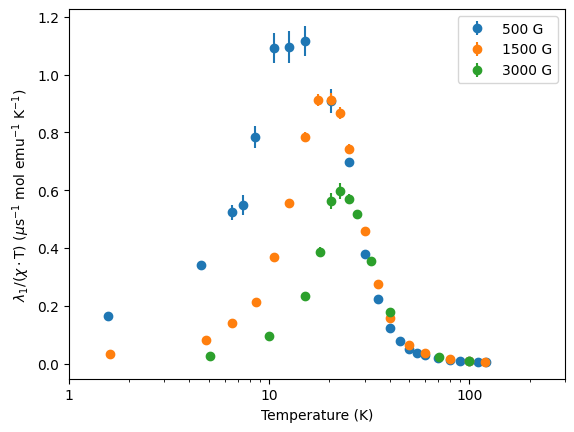

In [2]:
import os
import numpy as np
dpath = './data'  # data path

# --- Load data (skip header) ---
file='multicomp_multidataset_relaxations.dat' # data
file=os.path.join(
    dpath,
    file
)

data = np.loadtxt(file, delimiter=',', skiprows=1)

# """ LF-muSR relaxation rates $\lambda_1$ @ LG 500, 1500, 3000 Gauss
# Columns are define as:
# 0: temp
# 1: 500G_lambda
# 2: 500G_lambda_err
# 3: 1500G_lambda
# 4: 1500G_lambda_err
# 5: 3000G_lambda
# 6: 3000G_lambda_err
# """

# --- Let extract x, y_1, y_2, y_3 and err_1, err_2, err_3 seperately

xdat = data[:, 0]

xdat

cols = [0, 1, 3, 5]
data_xy_ = data[:, cols]
cols = [2, 4, 6]
data_xy_err_ = data[:, cols]

# --- We are interesting for 1500G and 3000G data only in this case
cols = [0, 3, 5]
xy = data[:, cols]
y_list = data[:, [3, 5]]

cols = [4, 6]
xy_err = data[:, cols]


# plot raw data
plt.figure()
plt.xscale('log')
plt.xlim([1, 300])
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\lambda_1/(\chi \cdot \mathrm{T})\ (\mu \mathrm{s}^{-1}\ \mathrm{mol \ emu}^{-1} \ \mathrm{K}^{-1})$')
field_lst = [500, 1500, 3000]  # in Gausss
# plt.plot(x, )
for i in range(1, data_xy_.shape[1]):
    # plt.plot(xdat, data_xy_[:, i], 'o')    
    plt.errorbar(xdat, data_xy_[:, i],  yerr=data_xy_err_[:, i-1], fmt='o', label=f'{field_lst[i-1]} G') 

plt.legend()


ax = plt.gca()
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation

second, model function to fit data...

In [3]:
import numpy as np
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Args::
        value (float): Value to be ensured not to be zero.

    Returns:
        float: Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))

def arrhenius(x, tau=1.0, sigma=1.0):
    """Calculate the Arrhenius function.

    arrhenius(x, tau, sigma) = tau * np.exp(sigma/x)
    
    Args:
        x (np.array): Temperature in Kelvin.
        tau (float): Infinite correlation time in units of sec
        sigma (float): Activation energy in units of Kelvin.

    Returns:
        array-like
    """
    sigma = max(tiny, sigma)  # units = [T], temperature 
    return tau * np.exp(sigma/x) # Arrhenius law, units = [sec]

def powerlaw(x, tau=1.0, exponent=1.0):
    """Return the powerlaw function.

    powerlaw(x, tau, exponent) = tau*x**(-exponent)

    Args:
        x (np.array): Temperature in Kelvin.
        tau (float): Infinite correlation time in units of sec
        exponent (float): Dimensionless exponent parameter.

    Returns:
        array-like
    """
    return tau*np.power(x, -1.0*exponent)


def slbpp_arrhenius(x, amplitude=1.0, tau=1.0, sigma=1.0, omega=1.0):
    """Return a simple "standard" Lorentzian BPP law lineshape with correlation function 
    that follows Arrhenius law.
    
    Args:
        x (np.array): Temperature in Kelvin.
        amplitude (float): Rescaling constant in units of sec^-2.
        tau (float): Infinite correlation time in units of sec that typically follows Arrhenius law.
            i.e. In Arrhenius law, a pre-exponential factor for tau_c =  tau*exp(sigma/x).
        sigma (float): Activation energy in units of Kelvin.
        omega (float): Larmor frequency i.e product gamma * field units of rad/sec.

    Returns:
        array-like
    """
    sigma = max(tiny, sigma)  # units = [T], temperature 
    omega = max(tiny, omega)  # units = [1/sec]
    tau_c = arrhenius(x, tau, sigma) # Arrhenius law, units = [sec]
    omega_tau_c = omega * tau_c # units = [1/sec] * [sec] = [1]
    omega_tau_c_sq = omega_tau_c*omega_tau_c # units = [1]
    denom = 1.0 + omega_tau_c_sq  # units = [1]
    jw =  tau_c / denom # units = [sec] / [1] = [sec] 
    # amplitude*jw # units = [1/sec]  * [1/sec]  * [sec] = [1/sec]  
    return amplitude*jw 


def slbpp_powerlaw(x, amplitude=1.0, tau=1.0, exponent=1.0, omega=1.0):
    """Return a simple "standard" Lorentzian BPP law lineshape with correlation function 
    that follows Power law.
    
    Args:
        x (np.array): Temperature in Kelvin.
        amplitude (float): Rescaling constant in units of sec^-2.
        tau (float): Infinite correlation time in units of sec that typically follows Arrhenius law.
            i.e In Power law, a pre-exponential factor for tau_c =  tau*x**(-exponent).
        exponent (float): dimensionless exponent parameter.
        omega (float): Larmor frequency i.e product gamma * field units of rad/sec.

    Returns:
        array-like
    """
    # sigma = max(tiny, sigma)  # units = [T], temperature 
    omega = max(tiny, omega)  # units = [1/sec]
    tau_c = powerlaw(x, tau, exponent) # Power law, units = [sec]
    omega_tau_c = omega * tau_c # units = [1/sec] * [sec] = [1]
    omega_tau_c_sq = omega_tau_c*omega_tau_c # units = [1]
    denom = 1.0 + omega_tau_c_sq  # units = [1]
    jw =  tau_c / denom # units = [sec] / [1] = [sec] 
    # amplitude*jw # units = [1/sec]  * [1/sec]  * [sec] = [1/sec]  
    return amplitude*jw 


def rlbpp_arrhenius(x, amplitude=1.0, tau=1.0, sigma=1.0, delta=1.0, omega=1.0):
    """Return refined "rectangular" BPP law lineshape with correlation function 
    that follows Arrhenius law.
    
    Args:
        x (np.array): Temperature in Kelvin.
        amplitude (float): Rescaling constant in units of sec^-2.
        tau (float): Infinite correlation time in units of sec that typically follows Arrhenius law.
            i.e. In Arrhenius law, a pre-exponential factor for tau_c =  tau*exp(sigma/x).
        sigma (float): Activation energy in units of Kelvin.
        delta (float): Width of rectangular distribution in units of Kelvin.
        omega (float): Larmor frequency i.e product gamma * field units of rad/sec.

    Returns:
        array-like
    """
    # if isinstance(x, (int, float)):
    #     x = max(tiny, x)
    # else:
    #     x[where(x <= tiny)] = tiny
    #
    sigma = max(tiny, sigma)  # units = [T], temperature 
    delta = max(tiny, delta)  # units = [T], temperature 
    omega = max(tiny, omega)  # units = [1/sec]
    tau_c = arrhenius(x, tau, sigma) # Arrhenius law, units = [sec]
    b = np.exp(delta/x) # units = [1]
    arg1 = np.arctan(b * omega * tau_c) # units = [1] * [1/sec] * [sec] = [1]
    arg2 = np.arctan(omega * tau_c / b) # units =  [1/sec] * [sec] / [1] = [1]
    r = (0.5*x)/max(tiny, (omega*delta)) # units = [T] / [ [1/sec] * [T]] = [sec]
    # scale = 1.0 * r # units = [sec]
    # amplitude * r * (arg1 - arg2) # units = [1/sec]  * [1/sec]  * [sec] = [1/sec]  
    return amplitude * r * (arg1 - arg2)


def rlbpp_powerlaw(x, amplitude=1.0, tau=1.0, exponent=1.0, delta=1.0, omega=1.0):
    """Return refined "rectangular" BPP law lineshape with correlation function 
    that follows Power law.
    
    Args:
        x (np.array): Temperature in Kelvin.
        amplitude (float): Rescaling constant in units of sec^-2.
        tau (float): Infinite correlation time in units of sec that typically follows Arrhenius law.
            i.e In Power law, a pre-exponential factor for tau_c =  tau*x**(-exponent).
        exponent (float): dimensionless exponent parameter.
        delta (float): Width of rectangular distribution in units of Kelvin.
        omega (float): Larmor frequency i.e product gamma * field units of rad/sec.

    Returns:
        array-like
    """
    # if isinstance(x, (int, float)):
    #     x = max(tiny, x)
    # else:
    #     x[where(x <= tiny)] = tiny
    #
    sigma = max(tiny, sigma)  # units = [T], temperature 
    delta = max(tiny, delta)  # units = [T], temperature 
    omega = max(tiny, omega)  # units = [1/sec]
    tau_c = powerlaw(x, tau, exponent) # Power law, units = [sec]
    b = np.exp(delta/x) # units = [1]
    arg1 = np.arctan(b * omega * tau_c) # units = [1] * [1/sec] * [sec] = [1]
    arg2 = np.arctan(omega * tau_c / b) # units =  [1/sec] * [sec] / [1] = [1]
    r = (0.5*x)/max(tiny, (omega*delta)) # units = [T] / [ [1/sec] * [T]] = [sec]
    # scale = 1.0 * r # units = [sec]
    # amplitude * r * (arg1 - arg2) # units = [1/sec]  * [1/sec]  * [sec] = [1/sec]  
    return amplitude * r * (arg1 - arg2)

one relaxation mechanism: **Raman or Raman-like**

built `data` and `function` **`item`** `dict` for `LmfitGlobal`  and fit...

In [4]:
# --- We are interesting for 1500G and 3000G data only in this case
x = data[:, 0]
y_list = data[:, [3, 5]]
y_errlist = data[:, [4, 6]]

init_slbpp = {
    'amplitude': {'value':2.0055e+08, 'vary':True, 'min':0, 'max':+np.inf},
    'tau': {'value':4.0e-4, 'vary':True, 'min':1.0e-8, 'max':1.0e-2},
    'exponent': {'value':3.5, 'vary':True, 'min':3.5-0.5, 'max':3.5+0.5},
    'omega': {'value':2e7, 'vary':False},
}

builder = (
    GlobalFitBuilder()
    .set_data(x, y_list)                      # x and all y datasets
    .add_model(slbpp_powerlaw, init_slbpp, func_kws={})
    .connect()                             # how to combine the  functions
)

items = builder.build()

call `LmfitGlobal`, `.fit()`, `.report()` and plot...

In [5]:
lg = LmfitGlobal(items, nan_policy='omit')

lg.init_params.pretty_print()  # pretty print initial parameters 

# --- Update omega ωL = γμ BL for 1500 G and 3000 G data ---

INFO: Parsing inputs...
INFO: Parsing input data...
INFO: Detected 2 dataset(s) with N=53 points each...
INFO: XRANGE: N=53 points each for user supplied xrange [1.56877, 120.45] ...
INFO: Parsing input data COMPLETED...
INFO: Parsing function models...
INFO: 1 model component(s) detected — single-component fit...
INFO: Parsing function models COMPLETED...
INFO: The model is to be constructed as...
INFO: ##############################################################
INFO: # y(x;) = slbpp_powerlaw(x, amplitude, tau, exponent, omega) #
INFO: ##############################################################
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the models(s) function(s)...
INFO: Building lmfit CompositeModel...
INFO: CompositeModel built successfully...
INFO: Initialized parameters...


Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0  2.006e+08        0      inf     None     True     None     None
amplitude_1  2.006e+08        0      inf     None     True     None     None
exponent_0        3.5        3        4     None     True     None     None
exponent_1        3.5        3        4     None     True     None     None
omega_0         2e+07     -inf      inf     None    False     None     None
omega_1         2e+07     -inf      inf     None    False     None     None
tau_0          0.0004    1e-08     0.01     None     True     None     None
tau_1          0.0004    1e-08     0.01     None     True     None     None


First, we need to update (fixed) $\omega_L = \gamma_{\mu}B_L$ value where $\gamma_{\mu}=0.0135538817~\text{MHz/G}$ for each field $B_L=1500, ~\text{and}~3000 ~\text{G}$.

This can be achieved using `.update_params()`:

```python
LmfitGlobal.update_params(
        self,
        *parlist: Iterable,
        overwrite_expr: bool = False            
    )
```

or with:

```python
LmfitGlobal.update_par(
        self,
        *parlist: Iterable,
        overwrite_expr: bool = False            
    )
```


where  `parlist` is of type: 
```python
*parlist: Union[str, list[str], lmfit.Parameter, lmfit.Parameters, Iterable, Dict]
```

In [6]:
def link_global(lg, names):
    lg.set_global(names, overwrite_expr=True)

GAMMA_MU_HZ_PER_GAUSS = 0.0135538817 * 1.0e6  # muon gyromagnetic ratio [MHz/G]
TWOPI = 2.0 * np.pi


fields_G = np.array([1500, 3000], dtype=float)  # Gauss
omegas = TWOPI * GAMMA_MU_HZ_PER_GAUSS * fields_G

In [7]:
ny, nc = 2, 1 # number of datasets and components

parlist = {
    f"omega_{j}": {"value": omega, "vary": False}
    for j, omega in enumerate(omegas)
}

# --- update omegas ---
lg.update_params(parlist, overwrite_expr=True)

# # --- set global params ---
# for j in range(ny):
# link_global(lg, [f"omega_{j}" for i in range(nc)])
# link_global(lg, [f"c{i}_omega_{j}" for i in range(nc)])
link_global(lg, [f"amplitude_{i}" for i in range(ny)])
link_global(lg, [f"exponent_{i}" for i in range(ny)])
link_global(lg, [f"tau_{i}" for i in range(ny)])

lg.init_params.pretty_print()  # pretty print initial parameters 

INFO: Updated parameter 'omega_0' with: {'value': np.float64(127742325.52903542), 'vary': False} ...
INFO: Updated parameter 'omega_1' with: {'value': np.float64(255484651.05807084), 'vary': False} ...
INFO: Tied parameters: 'amplitude_0' & 'amplitude_1' to reference='amplitude_0' ...
INFO: Tied parameters: 'exponent_0' & 'exponent_1' to reference='exponent_0' ...
INFO: Tied parameters: 'tau_0' & 'tau_1' to reference='tau_0' ...


Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0  2.006e+08        0      inf     None     True     None     None
amplitude_1  2.006e+08        0      inf     None    False amplitude_0     None
exponent_0        3.5        3        4     None     True     None     None
exponent_1        3.5        3        4     None    False exponent_0     None
omega_0      1.277e+08     -inf      inf     None    False     None     None
omega_1      2.555e+08     -inf      inf     None    False     None     None
tau_0          0.0004    1e-08     0.01     None     True     None     None
tau_1          0.0004    1e-08     0.01     None    False    tau_0     None


INFO: Fitting started (method='leastsq') ...
INFO: Parameters fit values:
INFO: Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: amplitude_0  2.588e+08        0      inf 5.934e+06     True     None     None
INFO: amplitude_1  2.588e+08        0      inf 5.934e+06    False amplitude_0     None
INFO: exponent_0       3.02        3        4   0.1031     True     None     None
INFO: exponent_1       3.02        3        4   0.1031    False exponent_0     None
INFO: omega_0      1.277e+08     -inf      inf        0    False     None     None
INFO: omega_1      2.555e+08     -inf      inf        0    False     None     None
INFO: tau_0        5.399e-05    1e-08     0.01 1.665e-05     True     None     None
INFO: tau_1        5.399e-05    1e-08     0.01 1.665e-05    False    tau_0     None
INFO: Coefficient of determination (R^2) statistics:
INFO: R-squared per dataset:
INFO:   R-squared data[:, 0] = 0.98780872
INFO:   R-squared data[:, 1] = 0.94947986
INFO:

[[Model]]
    Model(slbpp_powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 31
    # variables        = 3
    chi-square         = 0.05517526
    reduced chi-square = 0.00197055
    Akaike info crit   = -190.268060
    Bayesian info crit = -185.966098
    R-squared          = 0.97945254
[[Variables]]
    amplitude_0:  2.5882e+08 +/- 5934263.52 (2.29%) (init = 2.0055e+08)
    tau_0:        5.3995e-05 +/- 1.6646e-05 (30.83%) (init = 0.0004)
    exponent_0:   3.02033061 +/- 0.10311127 (3.41%) (init = 3.5)
    omega_0:      1.277423e+08 (fixed)
    amplitude_1:  2.5882e+08 +/- 5934263.53 (2.29%) == 'amplitude_0'
    tau_1:        5.3995e-05 +/- 1.6646e-05 (30.83%) == 'tau_0'
    exponent_1:   3.02033061 +/- 0.10311127 (3.41%) == 'exponent_0'
    omega_1:      2.554847e+08 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau_0, exponent_0)       = +0.9940
    C(amplitude_0, exponent_0) = +0.6073
    C(ampli

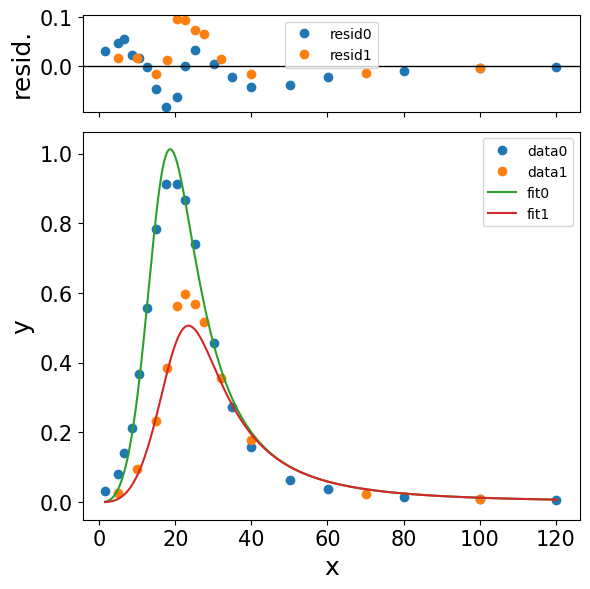

In [8]:
lg.fit(verbose=True)
lg.report()
# --- fancy plots ---
pretty_kw={'width': 6, 'height':6, 'dpi':100} # width and height and dpi of figure, or None to use default settings
ax1 = lg.plot_fit(plot_residual=True, numpoints=1024, xlabel='x', ylabel='y', pretty_kw=pretty_kw)  # plot fit parameters
# --- OR ---
# ax1 = lg.plot(plot_residual=True, show=True, numpoints=None, xlabel='x', ylabel='y', pretty_kw=pretty_kw)

two relaxation process: **Raman or Raman-like** and **Orbach**

built `data` and `function` **`item`** `dict` for `LmfitGlobal`  and fit...

In [9]:
# --- We are interesting for 1500G and 3000G data only in this case
x = data[:, 0]
y_list = data[:, [3, 5]]
y_errlist = data[:, [4, 6]]

init_slbpp_plaw = {
    'amplitude': {'value':2.0055e+08, 'vary':True, 'min':0, 'max':+np.inf},
    'tau': {'value':3.0e-4, 'vary':True, 'min':1.0e-9, 'max':1.0e-3},
    'exponent': {'value':3.5, 'vary':True, 'min':3.5-0.5, 'max':3.5+0.5},
    'omega': {'value':2e7, 'vary':False},
}

init_slbpp_arrh = {
    'amplitude': {'value':3.00e+07, 'vary':False, 'min':2.5e7, 'max':3.5e7},
    'tau': {'value':3.5e-13, 'vary':True, 'min':1.0e-13, 'max':1.0e-3},
    'sigma': {'value':330, 'vary':True, 'min':330-50, 'max':330+50},
    'omega': {'value':2e7, 'vary':False},
}

builder = (
    GlobalFitBuilder()
    .set_data(x, y_list)                      # x and all y datasets
    .add_model(slbpp_powerlaw,  init_slbpp_plaw, func_kws={})
    .add_model(slbpp_arrhenius, init_slbpp_arrh, func_kws={})
    .connect('+')                             # how to combine the  functions
)

items = builder.build()

call `LmfitGlobal`, `.fit()`, `.report()` and plot...

In [10]:
lg = LmfitGlobal(items, nan_policy='omit')

lg.init_params.pretty_print()  # pretty print initial parameters 

# --- Update omega ωL = γμ BL for 1500 G and 3000 G data ---

INFO: Parsing inputs...
INFO: Parsing input data...
INFO: Detected 2 dataset(s) with N=53 points each...
INFO: XRANGE: N=53 points each for user supplied xrange [1.56877, 120.45] ...
INFO: Parsing input data COMPLETED...
INFO: Parsing function models...
INFO: 2 model component(s) detected — multi-component fit...
INFO: The model connectors used: [+]
INFO: Parsing function models COMPLETED...
INFO: The model is to be constructed as...
INFO: ################################################################
INFO: # y(x;) = slbpp_powerlaw(x, amplitude, tau, exponent, omega) + #
INFO: # slbpp_arrhenius(x, amplitude, tau, sigma, omega)             #
INFO: ################################################################
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the models(s) function(s)...
INFO: Building lmfit CompositeModel...
INFO: CompositeModel built successfully...
INFO: Initialized parameters...


Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
c0_amplitude_0  2.006e+08        0      inf     None     True     None     None
c0_amplitude_1  2.006e+08        0      inf     None     True     None     None
c0_exponent_0        3.5        3        4     None     True     None     None
c0_exponent_1        3.5        3        4     None     True     None     None
c0_omega_0         2e+07     -inf      inf     None    False     None     None
c0_omega_1         2e+07     -inf      inf     None    False     None     None
c0_tau_0          0.0003    1e-09    0.001     None     True     None     None
c0_tau_1          0.0003    1e-09    0.001     None     True     None     None
c1_amplitude_0     3e+07  2.5e+07  3.5e+07     None    False     None     None
c1_amplitude_1     3e+07  2.5e+07  3.5e+07     None    False     None     None
c1_omega_0         2e+07     -inf      inf     None    False     None     None
c1_omega_1         2e+07     -inf      inf     N

In [11]:
ny, nc = 2, 2 # number of datasets and components

parlist = {
    f"c0_omega_{j}": {"value": omega, "vary": False}
    for j, omega in enumerate(omegas)
}

# --- update omegas ---
lg.update_params(parlist, overwrite_expr=True)

# --- set global params ---
GLOBAL_BY_COMPONENT = {
    "amplitude": lambda i: [f"c{i}_amplitude_{j}" for j in range(ny)],
    "tau":       lambda i: [f"c{i}_tau_{j}"       for j in range(ny)],
}

GLOBAL_BY_NAME = {
    "exponent": lambda: [f"c0_exponent_{j}" for j in range(ny)],
    "sigma":    lambda: [f"c1_sigma_{j}"    for j in range(ny)],
}

for j in range(ny):
    link_global(lg, [f"c{i}_omega_{j}" for i in range(nc)])

# Component-dependent globals
for i in range(nc):
    for fn in GLOBAL_BY_COMPONENT.values():
        # print(fn(i))
        link_global(lg, fn(i))

# Component-independent globals
for fn in GLOBAL_BY_NAME.values():
    # print(fn())
    link_global(lg, fn())


lg.init_params.pretty_print()  # pretty print initial parameters 

INFO: Updated parameter 'c0_omega_0' with: {'value': np.float64(127742325.52903542), 'vary': False} ...
INFO: Updated parameter 'c0_omega_1' with: {'value': np.float64(255484651.05807084), 'vary': False} ...
INFO: Tied parameters: 'c0_omega_0' & 'c1_omega_0' to reference='c0_omega_0' ...
INFO: Tied parameters: 'c0_omega_1' & 'c1_omega_1' to reference='c0_omega_1' ...
INFO: Tied parameters: 'c0_amplitude_0' & 'c0_amplitude_1' to reference='c0_amplitude_0' ...
INFO: Tied parameters: 'c0_tau_0' & 'c0_tau_1' to reference='c0_tau_0' ...
INFO: Tied parameters: 'c1_amplitude_0' & 'c1_amplitude_1' to reference='c1_amplitude_0' ...
INFO: Tied parameters: 'c1_tau_0' & 'c1_tau_1' to reference='c1_tau_0' ...
INFO: Tied parameters: 'c0_exponent_0' & 'c0_exponent_1' to reference='c0_exponent_0' ...
INFO: Tied parameters: 'c1_sigma_0' & 'c1_sigma_1' to reference='c1_sigma_0' ...


Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
c0_amplitude_0  2.006e+08        0      inf     None     True     None     None
c0_amplitude_1  2.006e+08        0      inf     None    False c0_amplitude_0     None
c0_exponent_0        3.5        3        4     None     True     None     None
c0_exponent_1        3.5        3        4     None    False c0_exponent_0     None
c0_omega_0      1.277e+08     -inf      inf     None    False     None     None
c0_omega_1      2.555e+08     -inf      inf     None    False     None     None
c0_tau_0          0.0003    1e-09    0.001     None     True     None     None
c0_tau_1          0.0003    1e-09    0.001     None    False c0_tau_0     None
c1_amplitude_0     3e+07  2.5e+07  3.5e+07     None    False     None     None
c1_amplitude_1     3e+07  2.5e+07  3.5e+07     None    False c1_amplitude_0     None
c1_omega_0      1.277e+08     -inf      inf     None    False c0_omega_0     None
c1_omega_1      2.555e+08 

INFO: Fitting started (method='leastsq') ...
INFO: Parameters fit values:
INFO: Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: c0_amplitude_0  2.498e+08        0      inf 6.219e+06     True     None     None
INFO: c0_amplitude_1  2.498e+08        0      inf 6.219e+06    False c0_amplitude_0     None
INFO: c0_exponent_0      3.042        3        4   0.1067     True     None     None
INFO: c0_exponent_1      3.042        3        4   0.1067    False c0_exponent_0     None
INFO: c0_omega_0      1.277e+08     -inf      inf        0    False     None     None
INFO: c0_omega_1      2.555e+08     -inf      inf        0    False     None     None
INFO: c0_tau_0        5.375e-05    1e-09    0.001 1.71e-05     True     None     None
INFO: c0_tau_1        5.375e-05    1e-09    0.001 1.71e-05    False c0_tau_0     None
INFO: c1_amplitude_0     3e+07  2.5e+07  3.5e+07        0    False     None     None
INFO: c1_amplitude_1     3e+07  2.5e+07  3.5e+07       

[[Model]]
    (Model(slbpp_powerlaw, prefix='c0_') + Model(slbpp_arrhenius, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 280
    # data points      = 31
    # variables        = 5
    chi-square         = 0.03955066
    reduced chi-square = 0.00152118
    Akaike info crit   = -196.588962
    Bayesian info crit = -189.419026
    R-squared          = 0.98527120
[[Variables]]
    c0_amplitude_0:  2.4984e+08 +/- 6218794.94 (2.49%) (init = 2.0055e+08)
    c0_tau_0:        5.3746e-05 +/- 1.7097e-05 (31.81%) (init = 0.0003)
    c0_exponent_0:   3.04199917 +/- 0.10672185 (3.51%) (init = 3.5)
    c0_omega_0:      1.277423e+08 (fixed)
    c1_amplitude_0:  3e+07 (fixed)
    c1_tau_0:        1.0011e-13 +/- 1.4368e-14 (14.35%) (init = 3.5e-13)
    c1_sigma_0:      280.032425 +/- 28.5917078 (10.21%) (init = 330)
    c1_omega_0:      1.2774e+08 +/- 0.00000000 (0.00%) == 'c0_omega_0'
    c0_amplitude_1:  2.4984e+08 +/- 6218794.94 (2.49%) == 'c0_amplitude_

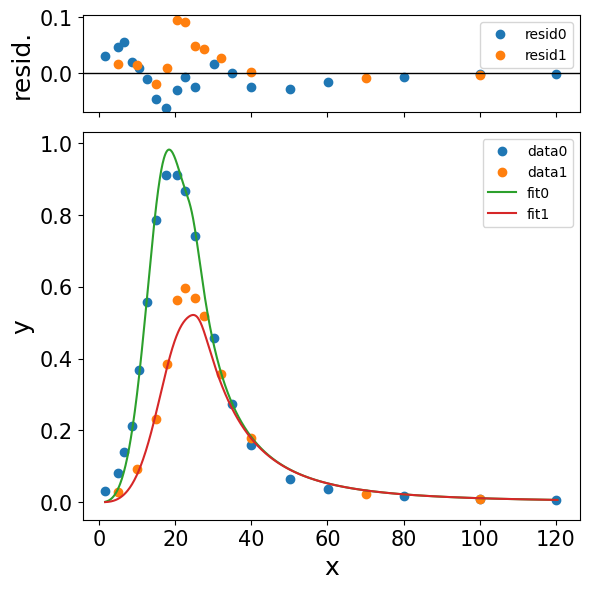

In [12]:
lg.fit(verbose=True)
lg.report()
# --- fancy plots ---
pretty_kw={'width': 6, 'height':6, 'dpi':100} # width and height and dpi of figure, or None to use default settings
ax1 = lg.plot_fit(plot_residual=True, numpoints=1024, xlabel='x', ylabel='y', pretty_kw=pretty_kw)  # plot fit parameters
# --- OR ---
# ax1 = lg.plot(plot_residual=True, show=True, numpoints=None, xlabel='x', ylabel='y', pretty_kw=pretty_kw)

three relaxation process: **Raman or Raman-like** and **Orbach** and **Direct**

built `data` and `function` **`item`** `dict` for `LmfitGlobal`  and fit...

In [13]:
# --- We are interesting for 1500G and 3000G data only in this case
x = data[:, 0]
y_list = data[:, [3, 5]]
y_errlist = data[:, [4, 6]]

init_slbpp_plaw1 = {
    'amplitude': {'value':2.0055e+08, 'vary':True, 'min':0, 'max':+np.inf},
    'tau': {'value':3.0e-4, 'vary':True, 'min':1.0e-9, 'max':1.0e-3},
    'exponent': {'value':3.5, 'vary':True, 'min':3.5-0.5, 'max':3.5+0.5},
    'omega': {'value':2e7, 'vary':False},
}

init_slbpp_arrh = {
    'amplitude': {'value':3.00e+07, 'vary':False, 'min':2.5e7, 'max':3.5e7},
    'tau': {'value':3.5e-13, 'vary':True, 'min':1.0e-13, 'max':1.0e-3},
    'sigma': {'value':330, 'vary':True, 'min':330-50, 'max':330+50},
    'omega': {'value':2e7, 'vary':False},
}

init_slbpp_plaw2 = {
    'amplitude': {'value':2.63e+07, 'vary':True, 'min':0, 'max':+np.inf},
    'tau': {'value':0.02141197, 'vary':False, 'min':0.02141197-0.01178750, 'max':0.02141197+0.01178750}, # value 0.02141197 +/- 0.01178750 (fixed)
    'exponent': {'value':11.0, 'vary':True, 'min':11.0-3, 'max':11.0+3},
    'omega': {'value':2e7, 'vary':False},
}

builder = (
    GlobalFitBuilder()
    .set_data(x, y_list)                      # x and all y datasets
    .add_model(slbpp_powerlaw,  init_slbpp_plaw1, func_kws={})
    .add_model(slbpp_arrhenius, init_slbpp_arrh,  func_kws={})
    .add_model(slbpp_powerlaw,  init_slbpp_plaw2, func_kws={})
    .connect('+', '+')                             # how to combine the  functions
)

items = builder.build()

call `LmfitGlobal`, `.fit()`, `.report()` and plot...

In [14]:
lg = LmfitGlobal(items, nan_policy='omit')

lg.init_params.pretty_print()  # pretty print initial parameters 

# --- Update omega ωL = γμ BL for 1500 G and 3000 G data ---

INFO: Parsing inputs...
INFO: Parsing input data...
INFO: Detected 2 dataset(s) with N=53 points each...
INFO: XRANGE: N=53 points each for user supplied xrange [1.56877, 120.45] ...
INFO: Parsing input data COMPLETED...
INFO: Parsing function models...
INFO: 3 model component(s) detected — multi-component fit...
INFO: The model connectors used: [+ +]
INFO: Parsing function models COMPLETED...
INFO: The model is to be constructed as...
INFO: ########################################################################
INFO: # y(x;) = slbpp_powerlaw(x, amplitude, tau, exponent, omega) +         #
INFO: # slbpp_arrhenius(x, amplitude, tau, sigma, omega) + slbpp_powerlaw(x, #
INFO: # amplitude, tau, exponent, omega)                                     #
INFO: ########################################################################
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the models(s) function(s)...
INFO: Building lmfit CompositeModel...
INFO: CompositeModel built succes

Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
c0_amplitude_0  2.006e+08        0      inf     None     True     None     None
c0_amplitude_1  2.006e+08        0      inf     None     True     None     None
c0_exponent_0        3.5        3        4     None     True     None     None
c0_exponent_1        3.5        3        4     None     True     None     None
c0_omega_0         2e+07     -inf      inf     None    False     None     None
c0_omega_1         2e+07     -inf      inf     None    False     None     None
c0_tau_0          0.0003    1e-09    0.001     None     True     None     None
c0_tau_1          0.0003    1e-09    0.001     None     True     None     None
c1_amplitude_0     3e+07  2.5e+07  3.5e+07     None    False     None     None
c1_amplitude_1     3e+07  2.5e+07  3.5e+07     None    False     None     None
c1_omega_0         2e+07     -inf      inf     None    False     None     None
c1_omega_1         2e+07     -inf      inf     N

In [15]:
ny, nc = 2, 3 # number of datasets and components

parlist = {
    f"c0_omega_{j}": {"value": omega, "vary": False}
    for j, omega in enumerate(omegas)
}

# --- update omegas ---
lg.update_params(parlist, overwrite_expr=True)

# --- set global params ---
GLOBAL_BY_COMPONENT = {
    "amplitude": lambda i: [f"c{i}_amplitude_{j}" for j in range(ny)],
    "tau":       lambda i: [f"c{i}_tau_{j}"       for j in range(ny)],
}

GLOBAL_BY_NAME = {
    "exponent": lambda: [f"c0_exponent_{j}" for j in range(ny)],
    "exponent": lambda: [f"c2_exponent_{j}" for j in range(ny)],
    "sigma":    lambda: [f"c1_sigma_{j}"    for j in range(ny)],
}

for j in range(ny):
    link_global(lg, [f"c{i}_omega_{j}" for i in range(nc)])

# Component-dependent globals
for i in range(nc):
    for fn in GLOBAL_BY_COMPONENT.values():
        # print(fn(i))
        link_global(lg, fn(i))

# Component-independent globals
for fn in GLOBAL_BY_NAME.values():
    # print(fn())
    link_global(lg, fn())


lg.init_params.pretty_print()  # pretty print initial parameters 

INFO: Updated parameter 'c0_omega_0' with: {'value': np.float64(127742325.52903542), 'vary': False} ...
INFO: Updated parameter 'c0_omega_1' with: {'value': np.float64(255484651.05807084), 'vary': False} ...
INFO: Tied parameters: 'c0_omega_0', 'c1_omega_0' & 'c2_omega_0' to reference='c0_omega_0' ...
INFO: Tied parameters: 'c0_omega_1', 'c1_omega_1' & 'c2_omega_1' to reference='c0_omega_1' ...
INFO: Tied parameters: 'c0_amplitude_0' & 'c0_amplitude_1' to reference='c0_amplitude_0' ...
INFO: Tied parameters: 'c0_tau_0' & 'c0_tau_1' to reference='c0_tau_0' ...
INFO: Tied parameters: 'c1_amplitude_0' & 'c1_amplitude_1' to reference='c1_amplitude_0' ...
INFO: Tied parameters: 'c1_tau_0' & 'c1_tau_1' to reference='c1_tau_0' ...
INFO: Tied parameters: 'c2_amplitude_0' & 'c2_amplitude_1' to reference='c2_amplitude_0' ...
INFO: Tied parameters: 'c2_tau_0' & 'c2_tau_1' to reference='c2_tau_0' ...
INFO: Tied parameters: 'c2_exponent_0' & 'c2_exponent_1' to reference='c2_exponent_0' ...
INFO: Ti

Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
c0_amplitude_0  2.006e+08        0      inf     None     True     None     None
c0_amplitude_1  2.006e+08        0      inf     None    False c0_amplitude_0     None
c0_exponent_0        3.5        3        4     None     True     None     None
c0_exponent_1        3.5        3        4     None     True     None     None
c0_omega_0      1.277e+08     -inf      inf     None    False     None     None
c0_omega_1      2.555e+08     -inf      inf     None    False     None     None
c0_tau_0          0.0003    1e-09    0.001     None     True     None     None
c0_tau_1          0.0003    1e-09    0.001     None    False c0_tau_0     None
c1_amplitude_0     3e+07  2.5e+07  3.5e+07     None    False     None     None
c1_amplitude_1     3e+07  2.5e+07  3.5e+07     None    False c1_amplitude_0     None
c1_omega_0      1.277e+08     -inf      inf     None    False c0_omega_0     None
c1_omega_1      2.555e+08     -

INFO: Fitting started (method='leastsq') ...
INFO: Parameters fit values:
INFO: Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: c0_amplitude_0  2.52e+08        0      inf 6.318e+06     True     None     None
INFO: c0_amplitude_1  2.52e+08        0      inf 6.318e+06    False c0_amplitude_0     None
INFO: c0_exponent_0      3.114        3        4   0.1138     True     None     None
INFO: c0_exponent_1      3.103        3        4   0.1113     True     None     None
INFO: c0_omega_0      1.277e+08     -inf      inf        0    False     None     None
INFO: c0_omega_1      2.555e+08     -inf      inf        0    False     None     None
INFO: c0_tau_0        6.654e-05    1e-09    0.001 2.247e-05     True     None     None
INFO: c0_tau_1        6.654e-05    1e-09    0.001 2.247e-05    False c0_tau_0     None
INFO: c1_amplitude_0     3e+07  2.5e+07  3.5e+07        0    False     None     None
INFO: c1_amplitude_1     3e+07  2.5e+07  3.5e+07        0   

[[Model]]
    ((Model(slbpp_powerlaw, prefix='c0_') + Model(slbpp_arrhenius, prefix='c1_'))
    + Model(slbpp_powerlaw, prefix='c2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 31
    # variables        = 8
    chi-square         = 0.03356951
    reduced chi-square = 0.00145954
    Akaike info crit   = -195.671852
    Bayesian info crit = -184.199954
    R-squared          = 0.98749860
[[Variables]]
    c0_amplitude_0:  2.5202e+08 +/- 6318316.94 (2.51%) (init = 2.0055e+08)
    c0_tau_0:        6.6544e-05 +/- 2.2473e-05 (33.77%) (init = 0.0003)
    c0_exponent_0:   3.11412470 +/- 0.11384894 (3.66%) (init = 3.5)
    c0_omega_0:      1.277423e+08 (fixed)
    c1_amplitude_0:  3e+07 (fixed)
    c1_tau_0:        1.0337e-13 +/- 4.1563e-14 (40.21%) (init = 3.5e-13)
    c1_sigma_0:      280.006087 +/- 22.3892545 (8.00%) (init = 330)
    c1_omega_0:      1.2774e+08 +/- 0.00000000 (0.00%) == 'c0_omega_0'
    c2_amplitude_0:  27453719

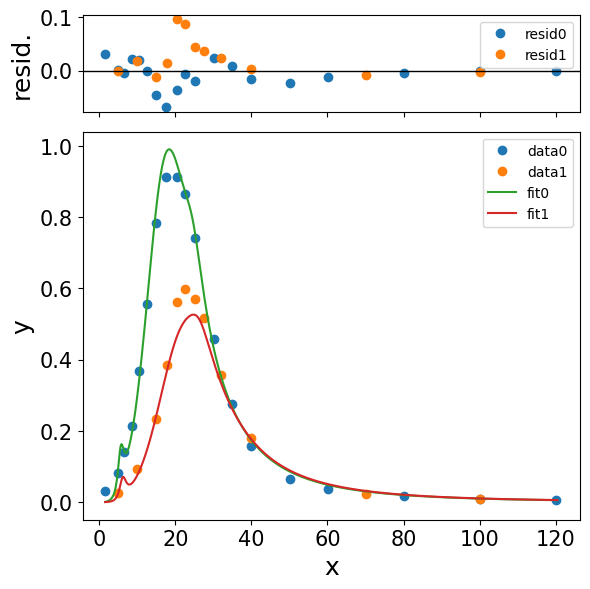

In [16]:
lg.fit(verbose=True)
lg.report()
# --- fancy plots ---
pretty_kw={'width': 6, 'height':6, 'dpi':100} # width and height and dpi of figure, or None to use default settings
ax1 = lg.plot_fit(plot_residual=True, numpoints=1024, xlabel='x', ylabel='y', pretty_kw=pretty_kw)  # plot fit parameters
# --- OR ---
# ax1 = lg.plot(plot_residual=True, show=True, numpoints=None, xlabel='x', ylabel='y', pretty_kw=pretty_kw)

FitData object: (includes components)

plotting and handling...

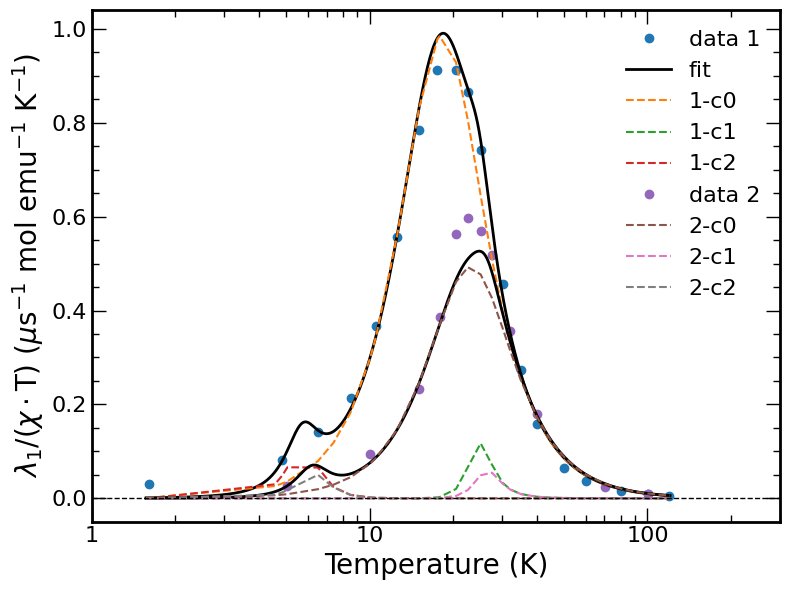

In [17]:
def _data_label(i: int, is_multidataset: bool) -> str | None:
    if is_multidataset:
        return f"data {i+1}"
    return "data" if i == 0 else None

def _fit_label(i: int, is_multidataset: bool, same_fit_color: bool) -> str | None:
    if not is_multidataset:
        return "fit" if i == 0 else None
    if same_fit_color:
        return "fit" if i == 0 else None
    return f"fit {i+1}"


fd = lg.get_fitdata(numpoints=6024) # int or None
fd.x_data
fd.resid_fit

fig, ax = plt.subplots(figsize=(8, 6), layout='tight')


for i in range(fd.ny):
    # --- data ---
    ax.plot(
        fd.x_data,
        fd.y_data[:, i],
        'o',
        zorder=1,
        label=_data_label(i, fd.is_multidataset),
    )

    # --- fit ---
    ax.plot(
        fd.x_model,
        fd.y_fit[:, i],
        '-',
        lw=2,
        color='k',
        zorder=2,
        label=_fit_label(i, fd.is_multidataset, same_fit_color=True)
        # label="fit" if i == fd.ny-1 else None, # ONE legend entry only
    )

    # --- components ---
    comps = None
    comps_names = None
    if fd.is_multicomponent:
        comps = fd.components
        comps_names = fd.component_names
        if fd.is_multidataset:
            comp = comps[i]
        else:
            comp = comps
        for name in comps_names:
            d_dict = comp[name]
            ax.plot(fd.x_data,  d_dict['data'],  '--', label=f'{i+1}-{name}')
            # ax.plot(fd.x_model, d_dict['model'], '--', label=name)

fontsize=16
ax.minorticks_on()
ax.axhline(y=0, lw=1, ls='--', color='k')
ylabel=r'$\lambda_1/(\chi \cdot \mathrm{T})\ (\mu \mathrm{s}^{-1}\ \mathrm{mol \ emu}^{-1} \ \mathrm{K}^{-1})$'
xlabel='Temperature (K)'
ax.set_xlabel(xlabel, fontsize=fontsize+4)
ax.set_ylabel(ylabel, fontsize=fontsize+4)
ax.tick_params(axis='x', labelsize=fontsize, labelcolor='k')  # Increase x-axis tick font size
ax.tick_params(axis='y', labelsize=fontsize, labelcolor='k')  # Increase y-axis tick font size
ax.tick_params(direction="in", which="both", top=True, right=True, labelsize=fontsize, labelcolor="k")
ax.tick_params(axis="both", which="major", length=10, width=1.0)
ax.tick_params(axis="both", which="minor", length=5,  width=1.0)
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.set_xscale('log')    
ax.set_xlim([1, 300])
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation

# ax.legend()
ax.legend(
    prop={
        "size": fontsize,
        "family": "sans-serif",
        "weight": "normal",
    },
    frameon=False,
)
plt.show()

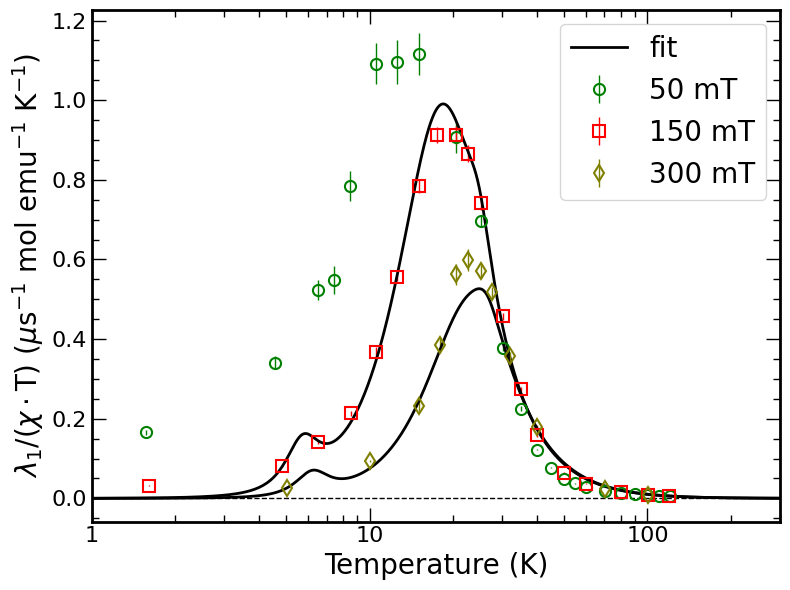

In [18]:
def _data_label(i: int, is_multidataset: bool) -> str | None:
    if is_multidataset:
        return f"data {i+1}"
    return "data" if i == 0 else None

def _data_label(i: int, is_multidataset: bool, label: str) -> str | None:
    if is_multidataset:
        return label
    return "data" if i == 0 else None

def _fit_label(i: int, is_multidataset: bool, same_fit_color: bool) -> str | None:
    if not is_multidataset:
        return "fit" if i == 0 else None
    if same_fit_color:
        return "fit" if i == 0 else None
    return f"fit {i+1}"


xfit = np.linspace(1, 400, num=6000)   # if more dense data is needed
# --- Also, we can extract initial and best fit as ---
init_fit = lg.init_fit   # default with x raw data
best_fit = lg.best_fit   # default with x raw data
# -- or 
init_fit = lg.eval(params=lg.init_params, x=xfit)  # using dense x-array
best_fit = lg.eval(x=xfit)  # using dense x-array

# --- components ----

comps = None
comps_names = None
if lg.is_multicomponent:
    comps = lg.eval_components()         # evaluate with x raw data define above
    comps = lg.eval_components(x_model=xfit)   # dense 
    comps_names = lg.component_names


fig, ax = plt.subplots(figsize=(8, 6), layout='tight')

# plot 500 G unfit data
x0 = data[:, 0]
y0 = data[:, 1]
y0_err = data[:, 2]

fmt='o'  
clr='green'
ax.errorbar(
    x0, y0, yerr=y0_err, 
    fmt=fmt, color=clr, ms=8, mew=1.5, mfc='white', mec=clr,
    capsize=0, capthick=0, elinewidth=1.0, fillstyle='none',
    label=f'50 mT'
    ) 


fields_G
color_lst = ['red', 'olive']
marker_lst = ['s', 'd']

for i in range(lg.ny):
    # --- data ---
    clr=color_lst[i]
    fmt=marker_lst[i]  
    # ax.plot(
    #     lg.x_data,
    #     lg.y_data[:, i],
    #     'o',
    #     zorder=1,
    #     label=_data_label(i, lg.is_multidataset),
    # )
    ax.errorbar(
        x0, y_list[:, i], yerr=y_errlist[:, i], 
        fmt=fmt, color=clr, ms=8, mew=1.5, mfc='white', mec=clr,
        capsize=0, capthick=0, elinewidth=1.0, fillstyle='none',
        # label=f'{fields_G[i]*0.1:.0f} mT'
        label=_data_label(i, lg.is_multidataset, f'{fields_G[i]*0.1:.0f} mT'),
        ) 
    
    # --- fit ---
    ax.plot(
        xfit, best_fit[:, i],
        '-', lw=2, color='k', zorder=2,
        label=_fit_label(i, lg.is_multidataset, same_fit_color=True)
        # label="fit" if i == fd.ny-1 else None, # ONE legend entry only
    )


fontsize=16
ax.minorticks_on()
ax.axhline(y=0, lw=1, ls='--', color='k')
ylabel=r'$\lambda_1/(\chi \cdot \mathrm{T})\ (\mu \mathrm{s}^{-1}\ \mathrm{mol \ emu}^{-1} \ \mathrm{K}^{-1})$'
xlabel='Temperature (K)'
ax.set_xlabel(xlabel, fontsize=fontsize+4)
ax.set_ylabel(ylabel, fontsize=fontsize+4)
ax.tick_params(axis='x', labelsize=fontsize, labelcolor='k')  # Increase x-axis tick font size
ax.tick_params(axis='y', labelsize=fontsize, labelcolor='k')  # Increase y-axis tick font size
ax.tick_params(direction="in", which="both", top=True, right=True, labelsize=fontsize, labelcolor="k")
ax.tick_params(axis="both", which="major", length=10, width=1.0)
ax.tick_params(axis="both", which="minor", length=5,  width=1.0)
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.set_xscale('log')    
ax.set_xlim([1, 300])
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation

# ax.legend()
ax.legend(
    prop={
        "size": fontsize+4,
        "family": "sans-serif",
        "weight": "normal",
    },
    frameon=True,
)
plt.show()

### **NOTE 1**

The BPP‑like behavior is reasonably well reproduced, in particular with a good scaling of the peak position and its intensity, which diminishes as $\sim 1/B_L$, as predicted by the BPP law.  

A deviation is observed at the lowest field $B_L = 50\,\text{mT}$, possibly because of the presence of internal fields with magnitude comparable to the externally applied one.  

Hence, based on this argument we safely conclude not to include this field in the global fitting procedure displayed and described above (in Fig. 4(a), *Phys. Rev. B* **111**, 014444 (2025)).

---

### **NOTE 2**

The fitted parameter amplitudes have a missing $10^6$ factor because the data were scaled by $10^{-6}$.  

Thus, the fitted amplitude values should be multiplied by $10^6$. For example: `c0_amplitude_0 = (2.5045e+08 +/- 6138594.75) x 10^6`